## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [86]:
## library imports here
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [87]:
df = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

In [88]:
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [89]:
df['diagnosis'] = df['diagnosis'].map({'No Disease': 0, 'Disease': 1})
X = df[['age', 'chol']]
y = df['diagnosis']

# Preprocessing and pipeline setup
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'chol'])
    ]
)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Cross-validate the pipeline
cv_scores = cross_val_score(lr_pipeline, X, y, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy: {:.3f}".format(cv_scores.mean()))

# Train the pipeline
lr_pipeline.fit(X, y)

# Predict on the entire dataset
y_pred = lr_pipeline.predict(X)
y_prob = lr_pipeline.predict_proba(X)[:, 1]

# Classification metrics
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("ROC AUC Score:", roc_auc_score(y, y_prob))

# Extract coefficients from the logistic regression model
logistic_model = lr_pipeline.named_steps['classifier']
scaler = lr_pipeline.named_steps['preprocessor'].named_transformers_['num']

# Coefficients and intercept
coefficients = logistic_model.coef_[0]  # ['age', 'chol']
intercept = logistic_model.intercept_[0]

# Standardization statistics
age_mean, chol_mean = scaler.mean_
age_std, chol_std = np.sqrt(scaler.var_)

# Calculate cholesterol levels for y = 0.5 and y = 0.9
age_standardized = (55 - age_mean) / age_std
chol_levels = {}

for y_val in [0.5, 0.9]:
    logit = np.log(y_val / (1 - y_val))  # log-odds
    chol_standardized = (logit - intercept - coefficients[0] * age_standardized) / coefficients[1]
    chol_actual = chol_standardized * chol_std + chol_mean  # Convert back to original scale
    chol_levels[f"y={y_val}"] = chol_actual

print("Cholesterol Levels:", chol_levels)

Cross-Validation Accuracy: 0.618
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.65      0.60        89
           1       0.69      0.60      0.64       115

    accuracy                           0.62       204
   macro avg       0.62      0.63      0.62       204
weighted avg       0.63      0.62      0.62       204

Confusion Matrix:
 [[58 31]
 [46 69]]
ROC AUC Score: 0.6415241817293601
Cholesterol Levels: {'y=0.5': np.float64(227.48905489228724), 'y=0.9': np.float64(-913.3896821737845)}


The cross-validation accuracy of **0.618** suggests that the model performs only slightly better than random guessing, indicating that the two predictors, `age` and `chol`, may not fully capture the relationship between the features and the diagnosis. This moderate performance suggests that the model's predictive power is limited, likely due to the simplicity of the feature set. Expanding the features to include other relevant variables, such as blood pressure, smoking habits, or family history, could improve accuracy.

The classification report reveals that the model performs slightly better at predicting `Disease` (Class 1) than `No Disease` (Class 0). For Class 1, the precision is **0.69**, meaning that 69% of cases predicted as `Disease` were correct. The recall is **0.60**, indicating that the model identified 60% of actual `Disease` cases. For Class 0, precision and recall are **0.56** and **0.65**, respectively, showing that the model struggles more with identifying `No Disease`. The weighted F1-scores (0.62 overall) reflect this moderate but imbalanced performance.

The confusion matrix confirms these observations, with 46 false negatives (actual disease cases classified as no disease) and 31 false positives. This highlights the model's difficulty in correctly classifying both classes. Improving model performance will require either better predictors or adjustments to balance precision and recall, depending on whether false negatives or false positives are more critical.

The ROC AUC score of **0.642** suggests moderate discriminatory ability, meaning the model can somewhat distinguish between the two classes across thresholds. However, this value is far from optimal, signaling that the model's ability to separate the two classes is limited.

Finally, the cholesterol thresholds calculated from the model for predicting disease probabilities raise concerns. At \( y = 0.5 \), the model predicts a cholesterol level of **227.49 mg/dL** as the threshold for a 50% chance of disease for a 55-year-old, which is reasonable. However, at \( y = 0.9 \), the model predicts an implausible negative cholesterol level (**-913.39 mg/dL**). This unrealistic result points to a significant issue, likely due to limitations in the model's ability to extrapolate for extreme probabilities. Possible reasons include insufficient training data in the high-probability range or improper scaling and regularization.

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [90]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'chol'])
    ]
)

lda_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis(solver='lsqr'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

cv_scores = cross_val_score(lda_pipeline, X, y, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy: {:.3f}".format(cv_scores.mean()))

# Train the pipeline
lda_pipeline.fit(X, y)

# Predict on the entire dataset
y_pred = lda_pipeline.predict(X)
y_prob = lda_pipeline.predict_proba(X)[:, 1]

# Classification metrics
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("ROC AUC Score:", roc_auc_score(y, y_prob))

# Extract LDA model parameters
lda_model = lda_pipeline.named_steps['classifier']
scaler = lda_pipeline.named_steps['preprocessor'].named_transformers_['num']

# Means and covariance from LDA
means = lda_model.means_  # Class means for predictors
priors = lda_model.priors_  # Class priors
covariance = lda_model.covariance_  # Shared covariance matrix

# Standardization parameters
age_mean, chol_mean = scaler.mean_
age_std, chol_std = np.sqrt(scaler.var_)

# Decision boundary coefficients
beta_1 = (means[1, 0] - means[0, 0]) / covariance[0, 0]  # Coefficient for 'age'
beta_2 = (means[1, 1] - means[0, 1]) / covariance[1, 1]  # Coefficient for 'chol'
beta_0 = -0.5 * (np.dot(means[1], np.linalg.inv(covariance).dot(means[1])) -
                 np.dot(means[0], np.linalg.inv(covariance).dot(means[0]))) + np.log(priors[1] / priors[0])

# For a 55-year-old, calculate cholesterol threshold
age_standardized = (55 - age_mean) / age_std
chol_standardized = -(beta_0 + beta_1 * age_standardized) / beta_2
chol_threshold = chol_standardized * chol_std + chol_mean

print(f"Cholesterol threshold for a 55-year-old: {chol_threshold}")

Cross-Validation Accuracy: 0.583
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.36      0.43        89
           1       0.60      0.75      0.67       115

    accuracy                           0.58       204
   macro avg       0.56      0.55      0.55       204
weighted avg       0.57      0.58      0.56       204

Confusion Matrix:
 [[32 57]
 [29 86]]
ROC AUC Score: 0.641133365901319
Cholesterol threshold for a 55-year-old: 303.13688845670316


The **cross-validation accuracy of 0.583** indicates that the LDA model's performance is slightly better than random guessing but less effective compared to the logistic regression model above. This suggests that the relationship between `age`, `chol`, and `diagnosis` may not be well-captured by the assumptions of LDA, particularly the linear separability and equal class covariance assumptions.

The **classification report** reveals that the model performs better at predicting `Disease` (Class 1) than `No Disease` (Class 0). For Class 1, precision is **0.60**, and recall is **0.75**, indicating the model captures the majority of disease cases but includes some false positives. For Class 0, the precision is **0.52**, and recall is **0.36**, showing poor performance in identifying cases with no disease. This imbalance is reflected in the macro and weighted averages, with relatively low F1-scores.

The **confusion matrix** confirms this imbalance, showing 86 true positives and 57 false positives for `Disease`. However, the model struggles significantly with `No Disease`, misclassifying 57 out of 89 cases. The **ROC AUC score of 0.641** aligns with these findings, indicating moderate discriminatory ability between the classes but with room for improvement.

The **cholesterol threshold for a 55-year-old** was calculated as approximately **303.14 mg/dL**. This threshold suggests that the model predicts `Disease` for cholesterol levels above this value. While this result is plausible, it is on the higher end of typical cholesterol levels, reflecting the model's bias towards identifying disease. Further refinement of the feature set or the model itself could help balance predictions and improve overall accuracy.

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [91]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'chol'])
    ]
)

# Pipeline for preprocessing and SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', probability=True))
])

# Define parameter grid for GridSearchCV tuning on C
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

# Best model and parameters
best_pipeline = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
y_pred = best_pipeline.predict(X)
y_prob = best_pipeline.predict_proba(X)[:, 1]

print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("ROC AUC Score:", roc_auc_score(y, y_prob))

# Extract coefficients from the SVC model
svc_model = best_pipeline.named_steps['classifier']
scaler = best_pipeline.named_steps['preprocessor'].named_transformers_['num']

# Coefficients for decision boundary
coef = svc_model.coef_[0]  # ['age', 'chol']
intercept = svc_model.intercept_[0]

# Standardization parameters
age_mean, chol_mean = scaler.mean_
age_std, chol_std = np.sqrt(scaler.var_)

# Solve for cholesterol threshold for a 55-year-old
age_standardized = (55 - age_mean) / age_std
chol_standardized = -(intercept + coef[0] * age_standardized) / coef[1]
chol_threshold = chol_standardized * chol_std + chol_mean

print(f"Cholesterol threshold for a 55-year-old: {chol_threshold}")

Best Parameters: {'classifier__C': 0.1}
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.29      0.38        89
           1       0.60      0.81      0.69       115

    accuracy                           0.58       204
   macro avg       0.57      0.55      0.53       204
weighted avg       0.57      0.58      0.55       204

Confusion Matrix:
 [[26 63]
 [22 93]]
ROC AUC Score: 0.35671714704445534
Cholesterol threshold for a 55-year-old: 368.4765747513584


The **best regularization parameter** for the SVC model was identified as **C = 0.1**, which balances the trade-off between the margin maximization and minimizing classification error. The **classification report** shows that the model performs better for predicting `Disease` (Class 1) than `No Disease` (Class 0). For Class 1, precision is **0.60**, and recall is **0.81**, meaning the model captures most disease cases but includes a notable number of false positives. For Class 0, the precision is **0.54**, and recall is **0.29**, indicating significant difficulty in correctly identifying cases without disease. The low F1-score for Class 0 further highlights the model's poor performance in this category. The weighted averages reflect an imbalanced performance across the two classes.

The **confusion matrix** confirms these findings, with 93 true positives and 63 false positives for `Disease`. However, the model struggles to correctly classify `No Disease`, misclassified 63 out of 89 cases. This imbalance in classification might result from the limited predictive power of using only `age` and `chol` as features or the imbalanced nature of the dataset. The **ROC AUC score of 0.357** is notably poor, indicating that the model has very limited ability to distinguish between the two classes across thresholds. This score suggests that the decision boundary might not align well with the actual data distribution.

The calculated **cholesterol threshold for a 55-year-old** is approximately **368.48 mg/dL**, which is strikingly high. This result suggests that the SVC decision boundary does not adequately capture the relationship between `age`, `chol`, and the diagnosis. The overly high threshold reflects the model's strong bias toward predicting `Disease`, given its high recall for Class 1 and low recall for Class 0.

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 10 rows containing missing values.


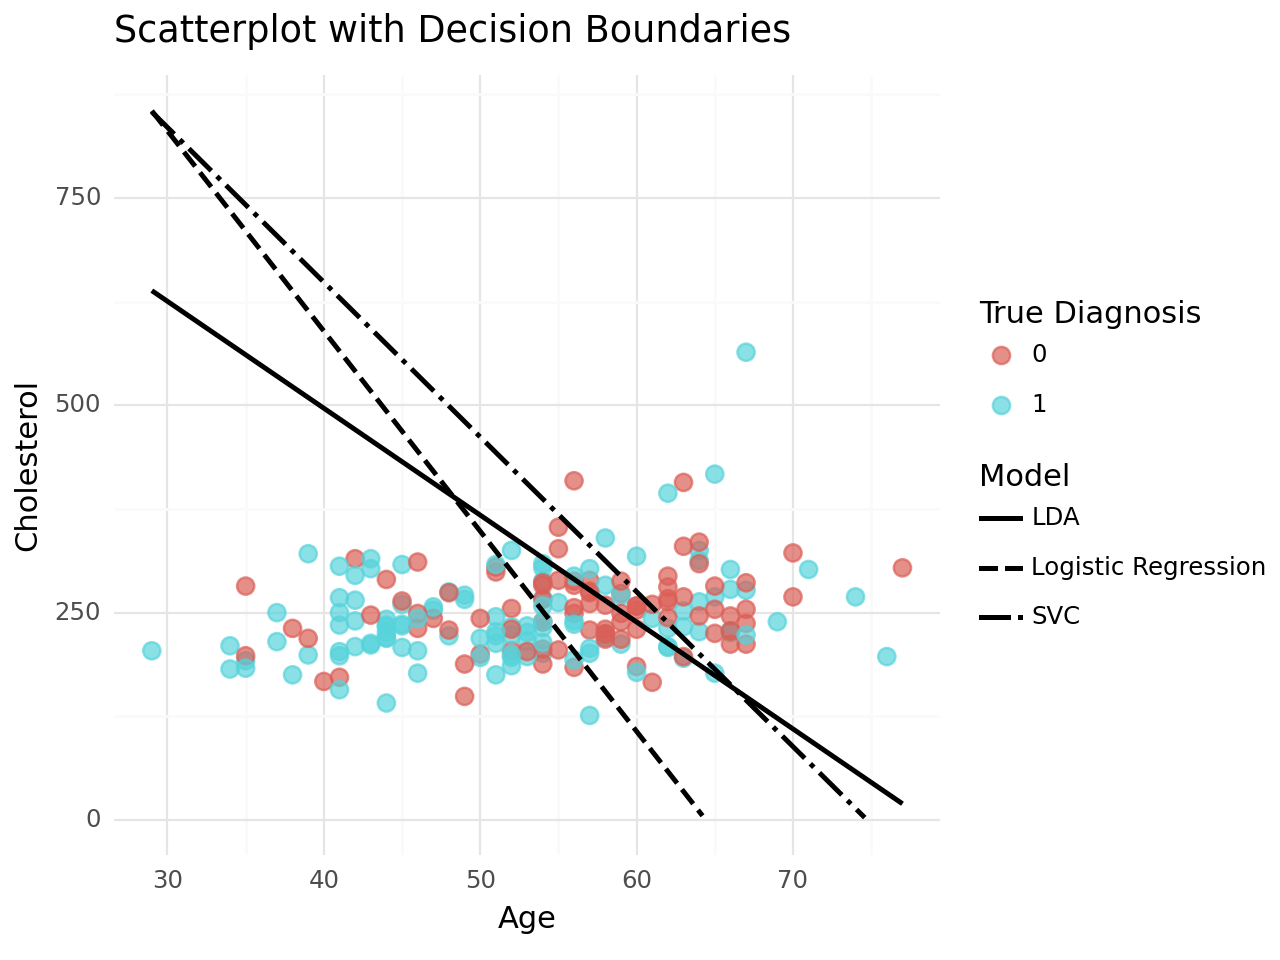

<Figure Size: (640 x 480)>

In [92]:
# Define age range for plotting decision boundaries
ages = np.linspace(df['age'].min(), df['age'].max(), 200)

# Standardize ages
ages_standardized = (ages - age_mean) / age_std

# Decision boundaries for Logistic Regression, LDA, and SVC in standardized space
chol_lr_standardized = -(logistic_model.intercept_ + logistic_model.coef_[0][0] * ages_standardized) / logistic_model.coef_[0][1]
chol_lda_standardized = -(beta_0 + beta_1 * ages_standardized) / beta_2
chol_svc_standardized = -(svc_model.intercept_ + svc_model.coef_[0][0] * ages_standardized) / svc_model.coef_[0][1]

# Reverse standardization for cholesterol to plot in original scale
chol_lr = chol_lr_standardized * chol_std + chol_mean
chol_lda = chol_lda_standardized * chol_std + chol_mean
chol_svc = chol_svc_standardized * chol_std + chol_mean

# Add decision boundaries to the dataset with a separate column for type
boundary_df = pd.DataFrame({
    'age': np.concatenate([ages, ages, ages]),
    'chol': np.concatenate([chol_lr, chol_lda, chol_svc]),
    'type': ['Boundary'] * (3 * len(ages)),
    'model': ['Logistic Regression'] * len(ages) +
             ['LDA'] * len(ages) +
             ['SVC'] * len(ages)
})

# Add a 'type' column to the original data
df_with_type = df.copy()
df_with_type['diagnosis'] = df_with_type['diagnosis'].astype('category')
df_with_type['type'] = 'Data'
df_with_type['model'] = 'Data'

# Combine the original data and decision boundaries
combined_df = pd.concat([df_with_type, boundary_df], ignore_index=True)

# Filtered datasets for points and lines
data_points = combined_df[combined_df['type'] == 'Data']
decision_boundaries = combined_df[combined_df['type'] == 'Boundary']

# Create the scatterplot with decision boundaries
plot = (
    ggplot() +
    geom_point(data=data_points, mapping=aes(x='age', y='chol', color='diagnosis'), size=3, alpha=0.7) +
    geom_line(
        data=decision_boundaries,
        mapping=aes(x='age', y='chol', linetype='model'),
        size=1
    ) +
    labs(
        title="Scatterplot with Decision Boundaries",
        x="Age",
        y="Cholesterol",
        color="True Diagnosis",
        linetype="Model"
    ) +
    ylim(0, None) +  # Set lower limit of y-axis to 0
    theme_minimal()
)

plot